In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
import zipfile as zp
import numpy as np
import pandas as pd
import re
from sklearn.metrics import mean_squared_error
import gc
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
df = pd.read_csv('/content/drive/MyDrive/ML/DA/train.zip', index_col = 0)
df

,visits
id,
1,30 84 126 135 137 179 242 342 426 456 460 462...
2,24 53 75 134 158 192 194 211 213 238 251 305 ...
3,51 143 173 257 446 491 504 510 559 616 719 73...
4,1 20 22 92 124 149 211 335 387 390 406 460 48...
5,34 51 56 106 110 121 163 233 266 275 345 359 ...
...,...
299996,6 12 15 30 33 48 49 50 55 56 70 74 76 83 84 9...
299997,4 7 12 18 19 35 41 53 55 60 75 77 81 82 91 95...
299998,1 9 15 17 29 31 42 49 62 74 85 105 109 113 11...


# Применим прогноз временного ряда с помощью ARIMA.
Преобразуем последовательность дней посещений в временной ряд, где номер дня недели 
зависит от номера посещения



In [ ]:
dseries = df.iloc[0]
id_i_visit = pd.DataFrame({'Days': dseries.str.split(' ')[0]}).iloc[1:].astype(int)
id_i_visit.Days = id_i_visit.Days.agg(lambda x: x % 7 + 1)

NameError: ignored

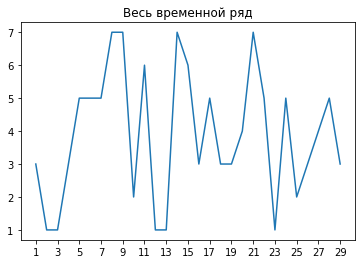

In [ ]:
fig, ax = plt.subplots()
ax.set_xticks(np.arange(min(id_i_visit.index), max(id_i_visit.index) + 1, 2))
plt.plot(id_i_visit.Days)
plt.title('Весь временной ряд')
plt.show()

Для демонстарции определим все предыдущие значения и подадим
моделе

In [ ]:
history = id_i_visit.Days.tolist()[0:-1]
print(len(history))

28


In [ ]:
len(id_i_visit.Days.tolist())

29

In [ ]:
model = ARIMA(history, order=(1, 0, 0))
model_fit = model.fit(gls = True)
output = model_fit.predict(start = len(id_i_visit.Days.tolist()), end = len(id_i_visit.Days.tolist()))

In [ ]:
int(output[-1])

3

Как видно на графике, для данного покупателя с периодом временного ряда равному трем, мы верно предсказали следующее посещение.


Text(0.5, 1.0, 'Результат работы')

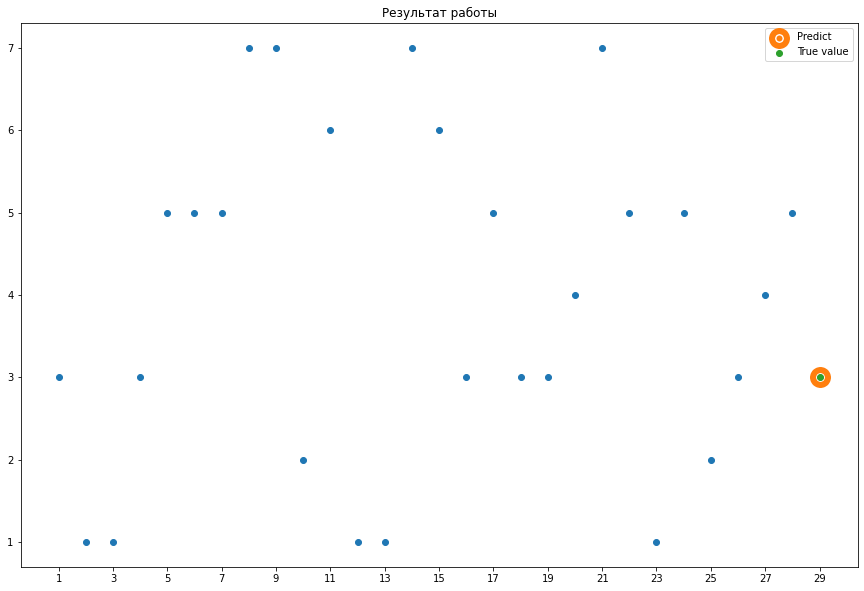

In [ ]:
fig, ax = plt.subplots(figsize = (15, 10))
ax.set_xticks(np.arange(min(id_i_visit.index), max(id_i_visit.index) + 1, 2))
plt.scatter(np.arange(min(id_i_visit.index), max(id_i_visit.index), 1), id_i_visit.Days.iloc[0:len(id_i_visit.Days.tolist()) - 1])
plt.scatter(len(id_i_visit.Days.tolist()), int(output[-1]), label = 'Predict', linewidth = 15)
plt.scatter(max(id_i_visit.index), id_i_visit.Days.iloc[len(id_i_visit.Days.tolist())-1], label = 'True value')
plt.legend()
plt.title('Результат работы')

# Обработка всего сета

## Проверка метода на выборке малого объема

In [ ]:
def CutLastWeak(arr, n = 1, last_day = 1099, nxt_day = 0):
    if(n == 0):
        return [arr, nxt_day]
    weak = 1
    line_day = last_day - 7 * weak
    cut_arr = arr[arr < line_day]
    nxt_day = arr[arr >= line_day]
    while(len(nxt_day) < 1):
        weak +=1 
        line_day = last_day - 7 * weak
        cut_arr = arr[arr <= line_day]
        nxt_day = arr[arr > line_day]
    return CutLastWeak(cut_arr, n - 1, line_day, nxt_day[0])

In [ ]:
id_i_visit = pd.DataFrame({'Days': df.iloc[0].str.split(' ')[0]}).iloc[1:].astype(int)
print(CutLastWeak(id_i_visit.Days.values.reshape(1, -1)[0], 2, 1099))
print(id_i_visit.Days.values.reshape(1, -1)[0].tolist())

[array([ 30,  84, 126, 135, 137, 179, 242, 342, 426, 456, 460, 462, 483,
       594, 600, 604, 704, 723, 744, 787, 804, 886, 924, 928, 946, 954]), 1039]
[30, 84, 126, 135, 137, 179, 242, 342, 426, 456, 460, 462, 483, 594, 600, 604, 704, 723, 744, 787, 804, 886, 924, 928, 946, 954, 1039, 1040, 1052]


In [ ]:
def Predict_True_test(df):
    import pandas as pd
    id_i_visit = pd.DataFrame({'Days': df.str.split(' ')[0]}).iloc[1:].astype(int)
    cut = CutLastWeak(id_i_visit.Days.values.reshape(1, -1)[0], 2, 1099) # Исключим последние две недели
    cut[1] = cut[1] % 7 + 1
    id_i_visit_cut = pd.DataFrame({'Days':cut[0]}).agg(lambda x: x % 7 + 1) #Преобразуем значения в ряд #Преобразуем значения в ряд
    history = id_i_visit_cut.Days.tolist() 
    try:
        for i in range(1, 14): #поиск оптимального периода
            p = i
            model = ARIMA(history, order=(p, 0, 0))
            model_fit = model.fit(disp = 0)
            output = model_fit.predict(start =len(id_i_visit_cut.Days.tolist())) #Найдем прогноз для n - 1 дня
            if(cut[1] == int(output[-1])): #Сравним с реальным значением
                break #Если предсказанное значение совпадает с реальным, то выходим из цикла оптимизации гиперпараметра
        cut = CutLastWeak(id_i_visit.Days.values.reshape(1, -1)[0], 1, 1099) # Исключим последние две недели
        id_i_visit_cut = pd.DataFrame({'Days':cut[0]}).agg(lambda x: x % 7 + 1) #Преобразуем значения в ряд #Преобразуем значения в ряд
        history = id_i_visit_cut.Days.tolist() 
        model = ARIMA(history, order=(p, 0, 0))
        model_fit = model.fit(disp = 0)
        cut[1] = cut[1] % 7 + 1
        output = model_fit.predict(start =len(id_i_visit_cut.Days.tolist())) #Найдем n - е значением
        if(int(output[-1]) == 0):
                return (int(np.round(np.random.uniform(1, 7))), cut[1])
        return (int(output[-1]), cut[1])
    except:
        return (int(np.round(np.random.uniform(1, 7))), cut[1])

In [ ]:
Predict_True_test(df.iloc[0])

(4, 3)

In [ ]:

df.shape

(300000, 1)

In [ ]:
from IPython.display import HTML, display
import time
def progress(value, max=100):
    return HTML("""
        <progress
            value='{value}'
            max='{max}',
            style='width: 100%'
        >
            {value}
        </progress>
    """.format(value=value, max=max))

In [ ]:
%%time
n = 1000
ds = df.sample(n)
out = display(progress(0, 100), display_id=True)
true = []
predict = []
for i in range(0, n):
        res = Predict_True_test(ds.iloc[i])
        predict.append(res[0])
        true.append(res[1])
        out.update(progress(i, n))
accuracy_score(true, predict)

CPU times: user 1h 6min, sys: 49min 5s, total: 1h 55min 5s
Wall time: 1h 44s


In [ ]:
print(f"ARIMA Score:{accuracy_score(true, predict)}")

ARIMA Score:0.111


In [ ]:
#baseline
predict_uni = list(map(int, np.random.uniform(1, 7, len(true))))
accuracy_score(true, predict_uni)

0.139

К сожалению, даже решение равномерного распределения работает лучше чем 
модель ARIMA

## Прогнозирование всего набора данных

In [ ]:
from IPython.display import HTML, display
import time
def progress(value, max=100):
    return HTML("""
        <progress
            value='{value}'
            max='{max}',
            style='width: 100%'
        >
            {value}
        </progress>
    """.format(value=value, max=max))

In [ ]:
def CutLastWeak(arr, n = 1, last_day = 1099, nxt_day = 0):
    if(n == 0):
        return [arr, nxt_day]
    weak = 1
    line_day = last_day - 7 * weak
    cut_arr = arr[arr < line_day]
    nxt_day = arr[arr >= line_day]
    while(len(nxt_day) < 1):
        weak +=1 
        line_day = last_day - 7 * weak
        cut_arr = arr[arr <= line_day]
        nxt_day = arr[arr > line_day]
    return CutLastWeak(cut_arr, n - 1, line_day, nxt_day[0])

In [ ]:
def Predict(df):
    import pandas as pd
    id_i_visit = pd.DataFrame({'Days': df.str.split(' ')[0]}).iloc[1:].astype(int)
    cut = CutLastWeak(id_i_visit.Days.values.reshape(1, -1)[0], 1, 1099) # Исключим последние две недели
    cut[1] = cut[1] % 7 + 1
    id_i_visit_cut = pd.DataFrame({'Days':cut[0]}).agg(lambda x: x % 7 + 1) #Преобразуем значения в ряд #Преобразуем значения в ряд
    history = id_i_visit_cut.Days.tolist() 
    try:
        for i in range(1, 10): #поиск оптимального периода
            p = i
            model = ARIMA(history, order=(p, 0, 0))
            model_fit = model.fit(disp = 0)
            output = model_fit.predict(start =len(id_i_visit_cut.Days.tolist())) #Найдем прогноз для n - 1 дня
            if(cut[1] == int(output[-1])): #Сравним с реальным значением
                break #Если предсказанное значение совпадает с реальным, то выходим из цикла оптимизации гиперпараметра
        
        id_i_visit_cut = id_i_visit.Days.agg(lambda x: x % 7 + 1) #Преобразуем значения в ряд #Преобразуем значения в ряд
        history = id_i_visit_cut.Days.tolist() 
        model = ARIMA(history, order=(p, 0, 0))
        model_fit = model.fit(disp = 0)
        cut[1] = cut[1] % 7 + 1
        output = model_fit.predict(start =len(id_i_visit_cut.Days.tolist())) #Найдем n - е значением
        if(int(output[-1]) == 0):
                return int(np.round(np.random.uniform(1, 7)))
        return int(output[-1])
    except:
        return int(np.round(np.random.uniform(1, 7)))

In [ ]:
%%time
import csv
n = df.shape[0]
solution = pd.DataFrame()
solution.to_csv('/content/drive/MyDrive/ML/DA/submission_ARIMA.csv')
out = display(progress(0, 100), display_id=True)
with open('/content/drive/MyDrive/ML/DA/submission_ARIMA.csv', 'w', newline='') as f:
    writer = csv.writer(f, quoting=csv.QUOTE_NONE)
    writer.writerow(['id','nextvisit'])
    for i in range(n):
        writer.writerow([str(int(i + 1)), str(int(Predict(df.iloc[i])))])
        out.update(progress(i, n)) 
    f.close()

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/pyt

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/lo

#Repeat

In [4]:
from IPython.display import HTML, display
import time
def progress(value, max=100):
    return HTML("""
        <progress
            value='{value}'
            max='{max}',
            style='width: 100%'
        >
            {value}
        </progress>
    """.format(value=value, max=max))

In [5]:
def CutLastWeak(arr, n = 1, last_day = 1099, nxt_day = 0):
    if(n == 0):
        return [arr, nxt_day]
    weak = 1
    line_day = last_day - 7 * weak
    cut_arr = arr[arr < line_day]
    nxt_day = arr[arr >= line_day]
    while(len(nxt_day) < 1):
        weak +=1 
        line_day = last_day - 7 * weak
        cut_arr = arr[arr <= line_day]
        nxt_day = arr[arr > line_day]
    return CutLastWeak(cut_arr, n - 1, line_day, nxt_day[0])

In [6]:
def Predict(df):
    import pandas as pd
    id_i_visit = pd.DataFrame({'Days': df.str.split(' ')[0]}).iloc[1:].astype(int)
    cut = CutLastWeak(id_i_visit.Days.values.reshape(1, -1)[0], 1, 1099) # Исключим последние две недели
    cut[1] = cut[1] % 7 + 1
    id_i_visit_cut = pd.DataFrame({'Days':cut[0]}).agg(lambda x: x % 7 + 1) #Преобразуем значения в ряд #Преобразуем значения в ряд
    history = id_i_visit_cut.Days.tolist() 
    try:
        for i in range(1, 10): #поиск оптимального периода
            p = i
            model = ARIMA(history, order=(p, 0, 0))
            model_fit = model.fit(disp = 0)
            output = model_fit.predict(start =len(id_i_visit_cut.Days.tolist())) #Найдем прогноз для n - 1 дня
            if(cut[1] == int(output[-1])): #Сравним с реальным значением
                break #Если предсказанное значение совпадает с реальным, то выходим из цикла оптимизации гиперпараметра
        
        id_i_visit_cut = id_i_visit.Days.agg(lambda x: x % 7 + 1) #Преобразуем значения в ряд #Преобразуем значения в ряд
        history = id_i_visit_cut.Days.tolist() 
        model = ARIMA(history, order=(p, 0, 0))
        model_fit = model.fit(disp = 0)
        cut[1] = cut[1] % 7 + 1
        output = model_fit.predict(start =len(id_i_visit_cut.Days.tolist())) #Найдем n - е значением
        if(int(output[-1]) == 0):
                return int(np.round(np.random.uniform(1, 7)))
        return int(output[-1])
    except:
        return int(np.round(np.random.uniform(1, 7)))

In [13]:
sb = pd.read_csv('/content/drive/MyDrive/ML/DA/submission_ARIMA.csv', index_col = 0)
display(sb.head())
display(sb.tail())
print(sb.shape)

,nextvisit
id,
1,6
2,4
3,1
4,7
5,7


,nextvisit
id,
299996,6
299997,3
299998,4
299999,1
300000,5


(300000, 1)


In [14]:
sb.nextvisit.describe()

count    300000.000000
mean          4.003750
std           1.779442
min           1.000000
25%           3.000000
50%           4.000000
75%           6.000000
max           7.000000
Name: nextvisit, dtype: float64

In [9]:
k = sb.index.values.tolist()[-1] + 1
k

292360

In [10]:
df.loc[k]

visits     11 12 13 14 17 24 28 47 48 49 50 51 57 59 60 ...
Name: 292360, dtype: object

In [11]:
from IPython.display import HTML, display
import time
def progress(value, max=100):
    return HTML("""
        <progress
            value='{value}'
            max='{max}',
            style='width: 100%'
        >
            {value}
        </progress>
    """.format(value=value, max=max))

In [12]:
%%time
import csv
n = df.shape[0]
out = display(progress(0, 100), display_id=True)
with open('/content/drive/MyDrive/ML/DA/submission_ARIMA.csv', 'a', newline='') as f:
    writer = csv.writer(f, quoting=csv.QUOTE_NONE)
    for i in range(k, n + 1):
        writer.writerow([str(int(i)), str(int(Predict(df.loc[i])))])
        out.update(progress(i, n)) 
    f.close()

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", Conve

CPU times: user 5h 28min 37s, sys: 4h 10min 29s, total: 9h 39min 7s
Wall time: 5h 5min 27s
